# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 30000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (30000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(28072, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

93.57333333333332

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(28072, 10)


1    23606
0     4466
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.
When I ordered these, I thought they were a bit pricey, but I decided to give them a try anyway.  I'm glad I did!  My dogs absolutely love these dried liver treats.  And, since my dogs are all small, I can cut the treats in half and still have large enough pieces to satisfy them. They're great for training; I'll definitely order them again, and would recommend them to anyone.
This was my favorite stevia product and I had it on subscribe and save until I queried customer service about NuNaturals GMO use.  Yes, NuNaturals uses GMO products.  SO, I've canceled my subscribe and save order and am now using <a href="http://www.amazon.com/gp/product/B001ELL3U0">Stevita Stevia Clear Liquid Extract, 3.3-Ounce Container (Pack of 3)</a>.
TOTALLY ORGASMIC.  these chips are the best spicy chip i have ever tasted.  signed up for the subscribe and save

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.
When I ordered these, I thought they were a bit pricey, but I decided to give them a try anyway.  I'm glad I did!  My dogs absolutely love these dried liver treats.  And, since my dogs are all small, I can cut the treats in half and still have large enough pieces to satisfy them. They're great for training; I'll definitely order them again, and would recommend them to anyone.
This was my favorite stevia product and I had it on subscribe and save until I queried customer service about NuNaturals GMO use.  Yes, NuNaturals uses GMO products.  SO, I've canceled my subscribe and save order and am now using Stevita Stevia Clear Liquid Extract, 3.3-Ounce Container (Pack of 3).
TOTALLY ORGASMIC.  these chips are the best spicy chip i have ever tasted.  signed up for the subscribe and save option.  the case contained 15(FIFTEEN, FULL SIZED BAGS) 

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

This was my favorite stevia product and I had it on subscribe and save until I queried customer service about NuNaturals GMO use.  Yes, NuNaturals uses GMO products.  SO, I have canceled my subscribe and save order and am now using <a href="http://www.amazon.com/gp/product/B001ELL3U0">Stevita Stevia Clear Liquid Extract, 3.3-Ounce Container (Pack of 3)</a>.


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

This was my favorite stevia product and I had it on subscribe and save until I queried customer service about NuNaturals GMO use Yes NuNaturals uses GMO products SO I have canceled my subscribe and save order and am now using a href http www amazon com gp product B001ELL3U0 Stevita Stevia Clear Liquid Extract 3 3 Ounce Container Pack of 3 a 


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████| 28072/28072 [00:11<00:00, 2354.07it/s]


In [23]:
preprocessed_reviews[1500]

'favorite stevia product subscribe save queried customer service nunaturals gmo use yes nunaturals uses gmo products canceled subscribe save order using'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [24]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.1] BAG OF WORDS

In [25]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaaaaaa', 'aaaand', 'aaah', 'aadp', 'aafco', 'aah']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (28072, 30623)
the number of unique words  30623


## [4.2] Bi-Grams and n-Grams.

In [26]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (28072, 5000)
the number of unique words including both unigrams and bigrams  5000


## [4.3] TF-IDF

In [27]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able buy', 'able drink', 'able eat', 'able enjoy', 'able find', 'able get', 'able give', 'able make']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (28072, 16784)
the number of unique words including both unigrams and bigrams  16784


## [4.4] Word2Vec

In [28]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [29]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('awesome', 0.8395121693611145), ('fantastic', 0.8301178216934204), ('excellent', 0.8023386001586914), ('good', 0.7899677753448486), ('amazing', 0.7869545817375183), ('wonderful', 0.760902464389801), ('decent', 0.7308604717254639), ('perfect', 0.7197684049606323), ('terrific', 0.6781874895095825), ('satisfied', 0.645891547203064)]
[('best', 0.7639616131782532), ('closest', 0.7561386823654175), ('greatest', 0.7281941771507263), ('tastiest', 0.7108751535415649), ('awful', 0.6860447525978088), ('ever', 0.6529477834701538), ('experienced', 0.6465742588043213), ('foul', 0.6450434327125549), ('alpine', 0.6349155902862549), ('douwe', 0.6303449273109436)]


In [30]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  9965
sample words  ['dogs', 'love', 'saw', 'pet', 'store', 'tag', 'attached', 'regarding', 'made', 'china', 'satisfied', 'safe', 'loves', 'chicken', 'product', 'wont', 'buying', 'anymore', 'hard', 'find', 'products', 'usa', 'one', 'isnt', 'bad', 'good', 'take', 'chances', 'till', 'know', 'going', 'imports', 'available', 'traps', 'unreal', 'course', 'total', 'fly', 'pretty', 'stinky', 'right', 'nearby', 'used', 'bait', 'seasons', 'ca', 'not', 'beat', 'great', 'received']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [31]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|███████████████████████████████████| 28072/28072 [00:46<00:00, 605.33it/s]


28072
50


#### [4.4.1.2] TFIDF weighted W2v

In [32]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [33]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|████████████████████████████████████| 28072/28072 [06:45<00:00, 69.23it/s]


# [5] Assignment 3: KNN

<ol>
    <li><strong>Apply Knn(brute force version) on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Apply Knn(kd tree version) on these feature sets</strong>
        <br><font color='red'>NOTE: </font>sklearn implementation of kd-tree accepts only dense matrices, you need to convert the sparse matrices of CountVectorizer/TfidfVectorizer into dense matices. You can convert sparse matrices to dense using .toarray() attribute. For more information please visit this <a href='https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.sparse.csr_matrix.toarray.html'>link</a>
        <ul>
            <li><font color='red'>SET 5:</font>Review text, preprocessed one converted into vectors using (BOW) but with restriction on maximum features generated.
            <pre>
            count_vect = CountVectorizer(min_df=10, max_features=500) 
            count_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 6:</font>Review text, preprocessed one converted into vectors using (TFIDF) but with restriction on maximum features generated.
            <pre>
                tf_idf_vect = TfidfVectorizer(min_df=10, max_features=500)
                tf_idf_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best K)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'> link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

In [34]:
with open('demo2.txt', 'w') as f:
    for item in tfidf_sent_vectors:
        f.write("%s\n" % item)

## [5.1] Applying KNN brute force

In [35]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve,auc
y = final['Score'].head(20000)
y.index = range(0,20000)

train_results = []
test_results = []
y_pred_test = []
fpr_list = []
tpr_list = []
fprt_list = []
tprt_list = []

def applyKNNBruteForce(X_train,X_test,y_train,y_test,n):
    model = KNeighborsClassifier(n_neighbors = n,algorithm = 'brute')
    model.fit(X_train,y_train)
    train_pred = model.predict_proba(X_train)[:,1]
    fpr,tpr,thresholds = roc_curve(y_train,train_pred)
    roc_auc = auc(fpr,tpr)
    train_results.append(roc_auc)
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    
    y_pred = model.predict_proba(X_test)[:,1]
    y_pred_test.append(y_pred)
    fprt,tprt,thresholds_t = roc_curve(y_test,y_pred)
    roc_auc_test = auc(fprt,tprt)
    test_results.append(roc_auc_test)
    fprt_list.append(fprt)
    tprt_list.append(tprt)

### [5.1.1] Applying KNN brute force on BOW,<font color='red'> SET 1</font>

In [36]:
# Please write all the code with proper documentation
X = pd.DataFrame(final_counts.toarray())
X = X.head(20000)
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(X, y, test_size=0.4, random_state=42)

In [37]:
applyKNNBruteForce(X_train_bow,X_test_bow,y_train_bow,y_test_bow,5)

In [38]:
applyKNNBruteForce(X_train_bow,X_test_bow,y_train_bow,y_test_bow,3)

In [39]:
applyKNNBruteForce(X_train_bow,X_test_bow,y_train_bow,y_test_bow,7)

In [40]:
applyKNNBruteForce(X_train_bow,X_test_bow,y_train_bow,y_test_bow,9)

In [41]:
applyKNNBruteForce(X_train_bow,X_test_bow,y_train_bow,y_test_bow,11)

In [42]:
applyKNNBruteForce(X_train_bow,X_test_bow,y_train_bow,y_test_bow,13)

In [43]:
applyKNNBruteForce(X_train_bow,X_test_bow,y_train_bow,y_test_bow,15)

In [44]:
applyKNNBruteForce(X_train_bow,X_test_bow,y_train_bow,y_test_bow,17)

In [45]:
applyKNNBruteForce(X_train_bow,X_test_bow,y_train_bow,y_test_bow,19)

In [46]:
applyKNNBruteForce(X_train_bow,X_test_bow,y_train_bow,y_test_bow,21)

In [47]:
def drawAUCScore(train_results,test_results):
    
    plt.plot([3,5,7,9,11,13,15,17,19,21], train_results,'r',label = "Train AUC")
    plt.plot([3,5,7,9,11,13,15,17,19,21], test_results,'b',label = "Test AUC")

    plt.ylabel('AUC score')
    plt.xlabel('alpha values')
    plt.show()

    print("AUC Score on trainig data")
    print(train_results)
    print("="*100)
    print("AUC Score on testing data")
    print(test_results)

In [48]:
def plotROC(fprtest,tprtest,fprtrain,tprtrain):
    
    plt.plot(fprtest,tprtest,'b')
    plt.plot(fprtrain,tprtrain,'r')
    plt.plot([0,1],[0,1],'g')
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.show()

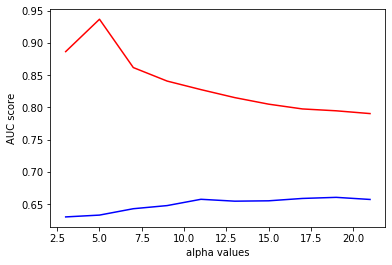

AUC Score on trainig data
[0.8864324648254299, 0.9366345752996352, 0.8617204794163627, 0.8407765763418447, 0.827527149557061, 0.8151322824387701, 0.8049841844710787, 0.7975745440333508, 0.7946755080771235, 0.7903703751954143]
AUC Score on testing data
[0.6301571633007513, 0.6329816853991405, 0.6428605346827571, 0.6477201025132137, 0.6574835387257469, 0.6545683307922768, 0.655123680191017, 0.6587941980523044, 0.6604937756856336, 0.6572278116199246]


In [49]:
drawAUCScore(train_results,test_results)

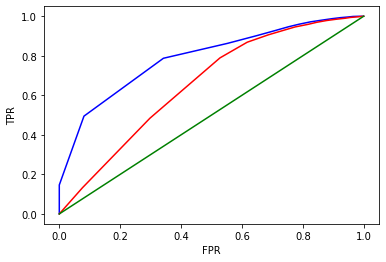

In [50]:
plotROC(list(fpr_list[9]),list(tpr_list[9]),list(fprt_list[9]),list(tprt_list[9]))

In [51]:
model = KNeighborsClassifier(n_neighbors = 21,algorithm = 'brute')
model.fit(X_train_bow,y_train_bow)

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=21, p=2,
                     weights='uniform')

In [52]:
test_bow_predict = model.predict(X_test_bow)

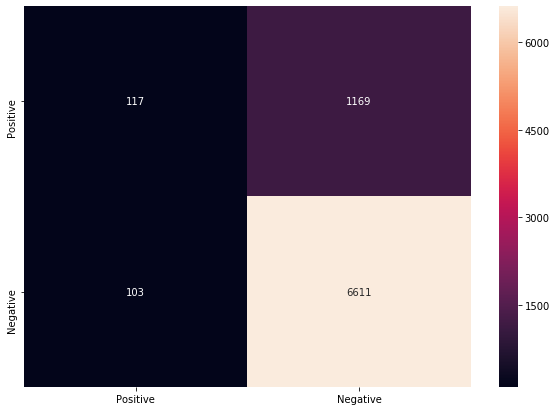

In [53]:
import seaborn as sns
# Confusion matrix with best k.
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_bow, test_bow_predict)
df_cm = pd.DataFrame(cm, index = ["Positive", "Negative"],
                  columns = ["Positive", "Negative"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True,fmt= 'g')

### [5.1.2] Applying KNN brute force on TFIDF,<font color='red'> SET 2</font>

In [54]:
train_results = []
test_results = []
y_pred_test = []
fpr_list = []
tpr_list = []
fprt_list = []
tprt_list = []

In [55]:
# Please write all the code with proper documentation
X = pd.DataFrame(final_tf_idf.toarray())
X = X.head(20000)
X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(X, y, test_size=0.4, random_state=42)

In [56]:
applyKNNBruteForce(X_train_tf,X_test_tf,y_train_tf,y_test_tf,3)

In [57]:
applyKNNBruteForce(X_train_tf,X_test_tf,y_train_tf,y_test_tf,5)

In [58]:
applyKNNBruteForce(X_train_tf,X_test_tf,y_train_tf,y_test_tf,7)

In [59]:
applyKNNBruteForce(X_train_tf,X_test_tf,y_train_tf,y_test_tf,9)

In [60]:
applyKNNBruteForce(X_train_tf,X_test_tf,y_train_tf,y_test_tf,11)

In [61]:
applyKNNBruteForce(X_train_tf,X_test_tf,y_train_tf,y_test_tf,13)

In [62]:
applyKNNBruteForce(X_train_tf,X_test_tf,y_train_tf,y_test_tf,15)

In [63]:
applyKNNBruteForce(X_train_tf,X_test_tf,y_train_tf,y_test_tf,17)

In [64]:
applyKNNBruteForce(X_train_tf,X_test_tf,y_train_tf,y_test_tf,19)

In [65]:
applyKNNBruteForce(X_train_tf,X_test_tf,y_train_tf,y_test_tf,21)

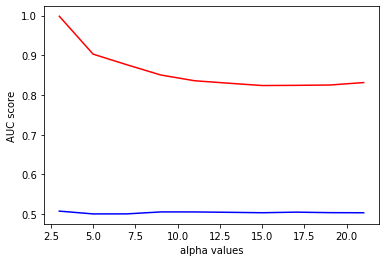

AUC Score on trainig data
[0.9983043251693591, 0.9029057321521625, 0.876135304846274, 0.8503755601875977, 0.835907087024492, 0.8297518759770715, 0.8238884835852006, 0.8243386138613862, 0.8251613600833767, 0.8313061750911933]
AUC Score on testing data
[0.5076800362835995, 0.5006414604056146, 0.5007582632979253, 0.5056523450221931, 0.5056255909635677, 0.5046832342622435, 0.503634614146249, 0.5050898148804452, 0.5038322003973963, 0.503555394336293]


In [66]:
drawAUCScore(train_results,test_results)

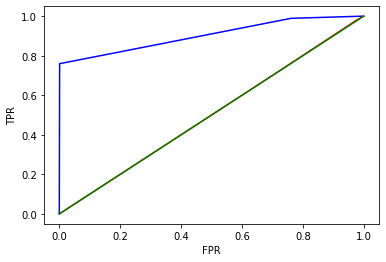

In [67]:
plotROC(list(fpr_list[1]),list(tpr_list[1]),list(fprt_list[1]),list(tprt_list[1]))

In [68]:
tf_model = KNeighborsClassifier(n_neighbors = 5,algorithm = 'brute')
tf_model.fit(X_train_tf,y_train_tf)

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [69]:
test_tf_predict =tf_model.predict(X_test_tf)

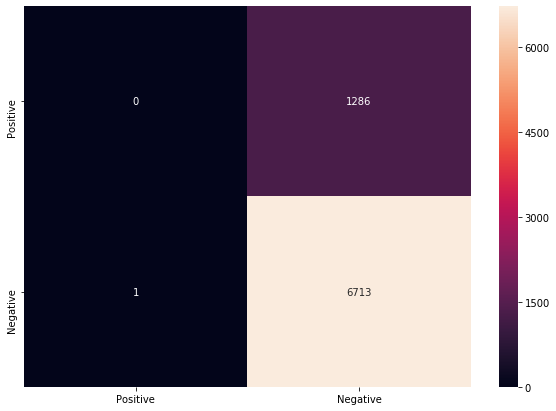

In [70]:
cm = confusion_matrix(y_test_tf, test_tf_predict)
df_cm = pd.DataFrame(cm, index = ["Positive", "Negative"],
                  columns = ["Positive", "Negative"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True,fmt= 'g')

### [5.1.3] Applying KNN brute force on AVG W2V,<font color='red'> SET 3</font>

In [71]:
# Please write all the code with proper documentation
sent_vectors_df = pd.DataFrame(sent_vectors)
X = sent_vectors_df.head(20000)

X_train_aw, X_test_aw, y_train_aw, y_test_aw = train_test_split(X, y, test_size=0.33, random_state=42)

train_results = []
test_results = []
y_pred_test = []
fpr_list = []
tpr_list = []
fprt_list = []
tprt_list = []

In [72]:
applyKNNBruteForce(X_train_aw,X_test_aw,y_train_aw,y_test_aw,3)

In [73]:
applyKNNBruteForce(X_train_aw,X_test_aw,y_train_aw,y_test_aw,5)

In [74]:
applyKNNBruteForce(X_train_aw,X_test_aw,y_train_aw,y_test_aw,7)

In [75]:
applyKNNBruteForce(X_train_aw,X_test_aw,y_train_aw,y_test_aw,9)

In [76]:
applyKNNBruteForce(X_train_aw,X_test_aw,y_train_aw,y_test_aw,11)

In [77]:
applyKNNBruteForce(X_train_aw,X_test_aw,y_train_aw,y_test_aw,13)

In [78]:
applyKNNBruteForce(X_train_aw,X_test_aw,y_train_aw,y_test_aw,15)

In [79]:
applyKNNBruteForce(X_train_aw,X_test_aw,y_train_aw,y_test_aw,17)

In [80]:
applyKNNBruteForce(X_train_aw,X_test_aw,y_train_aw,y_test_aw,19)

In [81]:
applyKNNBruteForce(X_train_aw,X_test_aw,y_train_aw,y_test_aw,21)

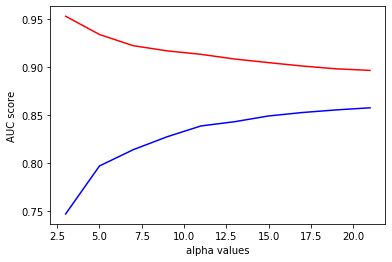

AUC Score on trainig data
[0.9533349978929625, 0.9342947324062368, 0.92261401179941, 0.9172480825958702, 0.9136125158027814, 0.9087034134007586, 0.904952402022756, 0.9014100716392751, 0.8984857142857143, 0.8968659502739149]
AUC Score on testing data
[0.7471790373207059, 0.7971996278015911, 0.8141876095069573, 0.8276418939635323, 0.8389198163589617, 0.8433687295890386, 0.8493347922014681, 0.8529227628183675, 0.8556541326915381, 0.8578479457279679]


In [82]:
drawAUCScore(train_results,test_results)

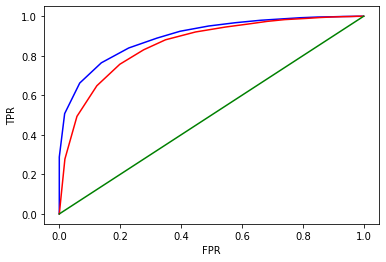

In [83]:
plotROC(list(fpr_list[9]),list(tpr_list[9]),list(fprt_list[9]),list(tprt_list[9]))

In [84]:
aw_model = KNeighborsClassifier(n_neighbors = 21,algorithm = 'brute')
aw_model.fit(X_train_aw,y_train_aw)
test_aw_predict = aw_model.predict(X_test_aw)

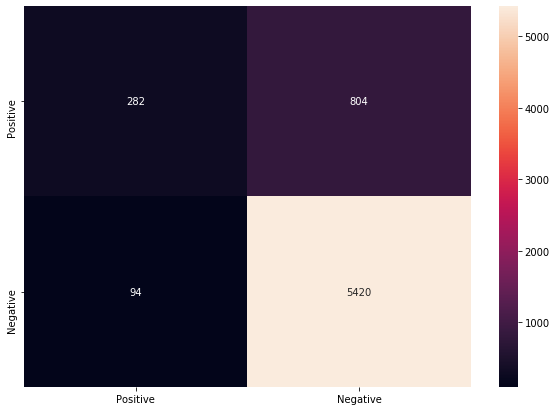

In [85]:
cm = confusion_matrix(y_test_aw, test_aw_predict)
df_cm = pd.DataFrame(cm, index = ["Positive", "Negative"],
                  columns = ["Positive", "Negative"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt = 'g')

### [5.1.4] Applying KNN brute force on TFIDF W2V,<font color='red'> SET 4</font>

In [86]:
# Please write all the code with proper documentation
tfidf_sent_vectors_df = pd.DataFrame(tfidf_sent_vectors)
X = tfidf_sent_vectors_df.head(20000)

X_train_wv, X_test_wv, y_train_wv, y_test_wv = train_test_split(X, y, test_size=0.33, random_state=42)


train_results = []
test_results = []
y_pred_test = []
fpr_list = []
tpr_list = []
fprt_list = []
tprt_list = []


In [87]:
applyKNNBruteForce(X_train_wv,X_test_wv,y_train_wv,y_test_wv,3)

In [88]:
applyKNNBruteForce(X_train_wv,X_test_wv,y_train_wv,y_test_wv,5)

In [89]:
applyKNNBruteForce(X_train_wv,X_test_wv,y_train_wv,y_test_wv,7)

In [90]:
applyKNNBruteForce(X_train_wv,X_test_wv,y_train_wv,y_test_wv,9)

In [91]:
applyKNNBruteForce(X_train_wv,X_test_wv,y_train_wv,y_test_wv,11)

In [92]:
applyKNNBruteForce(X_train_wv,X_test_wv,y_train_wv,y_test_wv,13)

In [93]:
applyKNNBruteForce(X_train_wv,X_test_wv,y_train_wv,y_test_wv,15)

In [94]:
applyKNNBruteForce(X_train_wv,X_test_wv,y_train_wv,y_test_wv,17)

In [95]:
applyKNNBruteForce(X_train_wv,X_test_wv,y_train_wv,y_test_wv,19)

In [96]:
applyKNNBruteForce(X_train_wv,X_test_wv,y_train_wv,y_test_wv,21)

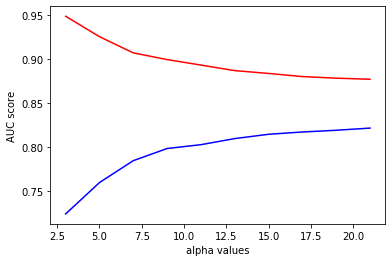

AUC Score on trainig data
[0.9487334808259587, 0.9255370206489676, 0.9071589549093975, 0.899552802359882, 0.8933292667509481, 0.8870365781710914, 0.8838112305099031, 0.8802880320269701, 0.8784750316055626, 0.8772088495575221]
AUC Score on testing data
[0.7244314822941904, 0.7600168598130591, 0.7848743128991598, 0.7986481422476589, 0.8029946040582451, 0.8099093651452087, 0.8147993956117727, 0.8174012608788879, 0.819351094251298, 0.821813017726183]


In [97]:
drawAUCScore(train_results,test_results)

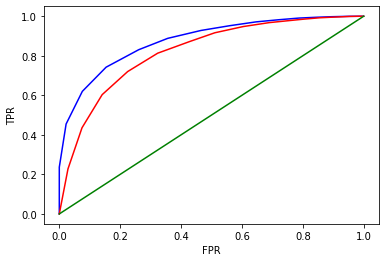

In [98]:
plotROC(list(fpr_list[9]),list(tpr_list[9]),list(fprt_list[9]),list(tprt_list[9]))

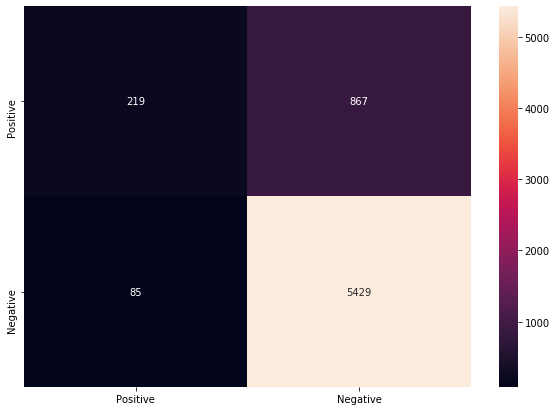

In [99]:
wv_model = KNeighborsClassifier(n_neighbors = 19,algorithm = 'brute')
wv_model.fit(X_train_wv,y_train_wv)
test_wv_predict = wv_model.predict(X_test_wv)
cm = confusion_matrix(y_test_wv, test_wv_predict)
df_cm = pd.DataFrame(cm, index = ["Positive", "Negative"],
                  columns = ["Positive", "Negative"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt = 'g')

## [5.2] Applying KNN kd-tree

### [5.2.1] Applying KNN kd-tree on BOW,<font color='red'> SET 5</font>

In [100]:
def applyKNNKDTree(X_train,X_test,y_train,y_test,n):
    model = KNeighborsClassifier(n_neighbors = n,algorithm = 'kd_tree')
    model.fit(X_train,y_train)
    train_pred = model.predict_proba(X_train)[:,1]
    fpr,tpr,thresholds = roc_curve(y_train,train_pred)
    roc_auc = auc(fpr,tpr)
    train_results.append(roc_auc)
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    
    
    y_pred = model.predict_proba(X_test)[:,1]
    y_pred_test.append(y_pred)
    fprt,tprt,thresholds_t = roc_curve(y_test,y_pred)
    roc_auc_test = auc(fprt,tprt)
    test_results.append(roc_auc_test)
    fprt_list.append(fprt)
    tprt_list.append(tprt)

In [101]:
# Please write all the code with proper documentation
count_vect = CountVectorizer(min_df=10, max_features=500) 
count_vect.fit(preprocessed_reviews)
final_counts = count_vect.transform(preprocessed_reviews)
X = pd.DataFrame(final_counts.toarray())
X = X.head(20000)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

train_results = []
test_results = []
y_pred_test = []
fpr_list = []
tpr_list = []
fprt_list = []
tprt_list = []

applyKNNKDTree(X_train,X_test,y_train,y_test,3)

In [102]:
applyKNNKDTree(X_train,X_test,y_train,y_test,5)

In [103]:
applyKNNKDTree(X_train,X_test,y_train,y_test,7)

In [104]:
applyKNNKDTree(X_train,X_test,y_train,y_test,9)

In [105]:
applyKNNKDTree(X_train,X_test,y_train,y_test,11)

In [106]:
applyKNNKDTree(X_train,X_test,y_train,y_test,13)

In [107]:
applyKNNKDTree(X_train,X_test,y_train,y_test,15)

In [108]:
applyKNNKDTree(X_train,X_test,y_train,y_test,17)

In [109]:
applyKNNKDTree(X_train,X_test,y_train,y_test,19)

In [110]:
applyKNNKDTree(X_train,X_test,y_train,y_test,21)

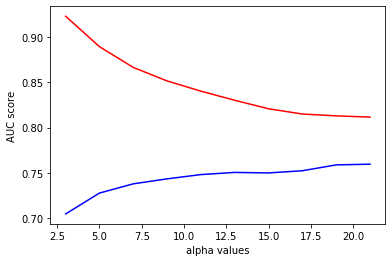

AUC Score on trainig data
[0.9226698904340498, 0.8891416139907291, 0.8662643067846607, 0.8513708386009271, 0.8401411715128528, 0.8300784028655709, 0.8207279182469447, 0.8149330804888326, 0.8129023598820059, 0.8115207964601769]
AUC Score on testing data
[0.704879626679385, 0.7278631456109377, 0.7380217006635046, 0.7435104916265377, 0.7482227559381746, 0.7506075277328562, 0.7500349854480575, 0.7524502338263693, 0.7589005818773041, 0.7596771920261902]


In [111]:
drawAUCScore(train_results,test_results)

In [112]:
model_kd_bow = KNeighborsClassifier(n_neighbors = 13,algorithm = 'kd_tree')
model_kd_bow.fit(X_train,y_train)

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=13, p=2,
                     weights='uniform')

In [113]:
test_aw_predict = model_kd_bow.predict(X_test)

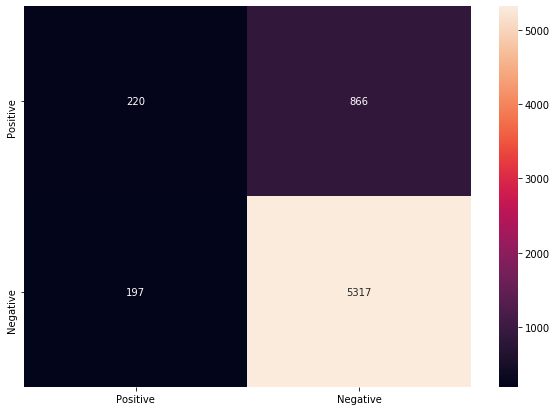

In [114]:
cm = confusion_matrix(y_test, test_aw_predict)
df_cm = pd.DataFrame(cm, index = ["Positive", "Negative"],
                  columns = ["Positive", "Negative"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True,fmt = 'g')

### [5.2.2] Applying KNN kd-tree on TFIDF,<font color='red'> SET 6</font>

In [115]:
# Please write all the code with proper documentation
tf_idf_vect = TfidfVectorizer(min_df=10, max_features=500)
tf_idf_vect.fit(preprocessed_reviews)


tf_counts = tf_idf_vect.transform(preprocessed_reviews)
X = pd.DataFrame(tf_counts.toarray())
X = X.head(20000)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

train_results = []
test_results = []
y_pred_test = []
fpr_list = []
tpr_list = []
fprt_list = []
tprt_list = []


In [116]:
applyKNNKDTree(X_train,X_test,y_train,y_test,3)

In [117]:
applyKNNKDTree(X_train,X_test,y_train,y_test,5)

In [118]:
applyKNNKDTree(X_train,X_test,y_train,y_test,7)

In [119]:
applyKNNKDTree(X_train,X_test,y_train,y_test,9)

In [120]:
applyKNNKDTree(X_train,X_test,y_train,y_test,11)

In [121]:
applyKNNKDTree(X_train,X_test,y_train,y_test,13)

In [122]:
applyKNNKDTree(X_train,X_test,y_train,y_test,15)

In [123]:
applyKNNKDTree(X_train,X_test,y_train,y_test,17)

In [124]:
applyKNNKDTree(X_train,X_test,y_train,y_test,19)

In [125]:
applyKNNKDTree(X_train,X_test,y_train,y_test,21)

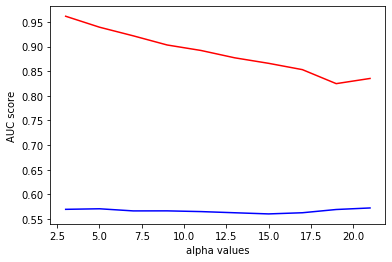

AUC Score on trainig data
[0.9614189633375474, 0.939200779603877, 0.9216541508638855, 0.9031265697429416, 0.892002823430257, 0.8770678044669196, 0.8659180362410451, 0.8530942056468606, 0.8246882216603455, 0.8352018963337549]
AUC Score on testing data
[0.5696978593247657, 0.5708229044969075, 0.5665044978427588, 0.5665923372016051, 0.565118105528803, 0.5627434369303385, 0.5603973244732477, 0.562769655142009, 0.5693422435174217, 0.5724846715308963]


In [126]:
drawAUCScore(train_results,test_results)

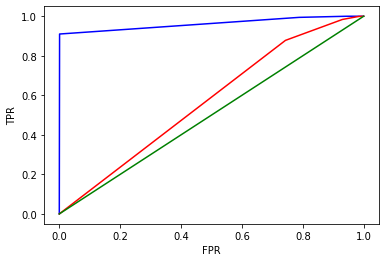

In [127]:
plotROC(list(fpr_list[0]),list(tpr_list[0]),list(fprt_list[0]),list(tprt_list[0]))

In [128]:
model_kd_tf = KNeighborsClassifier(n_neighbors = 3,algorithm = 'kd_tree')
model_kd_tf.fit(X_train,y_train)

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

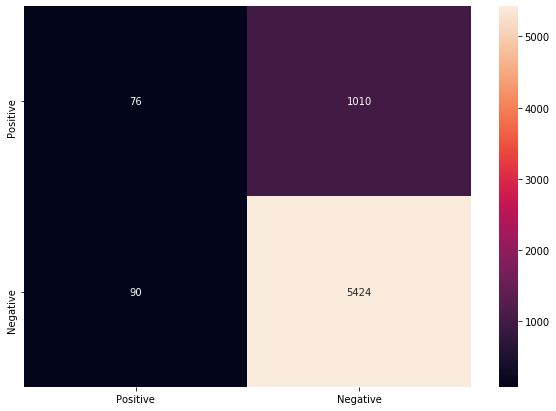

In [129]:
test_tf_predict = model_kd_tf.predict(X_test)
cm = confusion_matrix(y_test, test_tf_predict)
df_cm = pd.DataFrame(cm, index = ["Positive", "Negative"],
                  columns = ["Positive", "Negative"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt = 'g')

### [5.2.3] Applying KNN kd-tree on AVG W2V,<font color='red'> SET 3</font>

In [130]:
# Please write all the code with proper documentation
sent_vectors_df = pd.DataFrame(sent_vectors)
X = sent_vectors_df.head(20000)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

train_results = []
test_results = []
y_pred_test = []
fpr_list = []
tpr_list = []
fprt_list = []
tprt_list = []

In [131]:
applyKNNKDTree(X_train,X_test,y_train,y_test,3)

In [132]:
applyKNNKDTree(X_train,X_test,y_train,y_test,5)

In [133]:
applyKNNKDTree(X_train,X_test,y_train,y_test,7)

In [134]:
applyKNNKDTree(X_train,X_test,y_train,y_test,9)

In [135]:
applyKNNKDTree(X_train,X_test,y_train,y_test,11)

In [136]:
applyKNNKDTree(X_train,X_test,y_train,y_test,13)

In [137]:
applyKNNKDTree(X_train,X_test,y_train,y_test,15)

In [138]:
applyKNNKDTree(X_train,X_test,y_train,y_test,17)

In [139]:
applyKNNKDTree(X_train,X_test,y_train,y_test,19)

In [140]:
applyKNNKDTree(X_train,X_test,y_train,y_test,21)

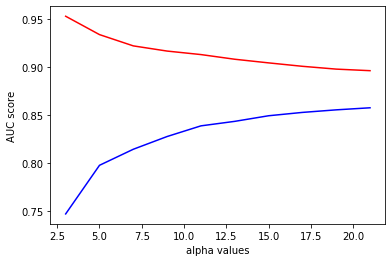

AUC Score on trainig data
[0.9533349978929625, 0.9341856300042141, 0.9224225663716814, 0.9170126843657818, 0.9133604298356511, 0.9084863253265908, 0.9046985040033713, 0.9011257901390645, 0.8981926885798568, 0.896562368310156]
AUC Score on testing data
[0.7471790373207059, 0.7978768759380943, 0.8146186235472271, 0.8279027401204101, 0.8390180929039825, 0.8437144926926337, 0.849552386658838, 0.8530401602884605, 0.8557140003914362, 0.8578638102509534]


In [141]:
drawAUCScore(train_results,test_results)

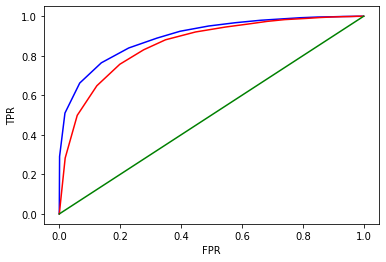

In [142]:
plotROC(list(fpr_list[9]),list(tpr_list[9]),list(fprt_list[9]),list(tprt_list[9]))

In [143]:
model_kd_aw = KNeighborsClassifier(n_neighbors = 21,algorithm = 'kd_tree')
model_kd_aw.fit(X_train,y_train)

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=21, p=2,
                     weights='uniform')

In [144]:
test_aw_predict = model_kd_aw.predict(X_test)

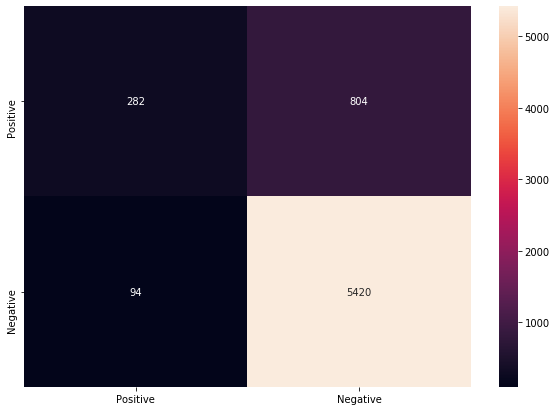

In [145]:
cm = confusion_matrix(y_test, test_aw_predict)
df_cm = pd.DataFrame(cm, index = ["Positive", "Negative"],
                  columns = ["Positive", "Negative"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True,fmt = 'g')

### [5.2.4] Applying KNN kd-tree on TFIDF W2V,<font color='red'> SET 4</font>

In [146]:
# Please write all the code with proper documentation
tfidf_sent_vectors_df = pd.DataFrame(tfidf_sent_vectors)
X = tfidf_sent_vectors_df.head(20000)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


train_results = []
test_results = []
y_pred_test = []
fpr_list = []
tpr_list = []
fprt_list = []
tprt_list = []


In [147]:
applyKNNKDTree(X_train,X_test,y_train,y_test,3)

In [148]:
applyKNNKDTree(X_train,X_test,y_train,y_test,5)

In [149]:
applyKNNKDTree(X_train,X_test,y_train,y_test,7)

In [150]:
applyKNNKDTree(X_train,X_test,y_train,y_test,9)

In [151]:
applyKNNKDTree(X_train,X_test,y_train,y_test,11)

In [152]:
applyKNNKDTree(X_train,X_test,y_train,y_test,13)

In [153]:
applyKNNKDTree(X_train,X_test,y_train,y_test,15)

In [154]:
applyKNNKDTree(X_train,X_test,y_train,y_test,17)

In [155]:
applyKNNKDTree(X_train,X_test,y_train,y_test,19)

In [156]:
applyKNNKDTree(X_train,X_test,y_train,y_test,21)

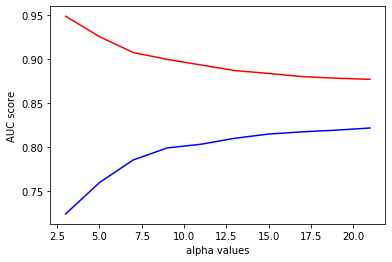

AUC Score on trainig data
[0.9487334808259587, 0.9255370206489676, 0.9075569953645175, 0.8997839233038348, 0.8934695533080489, 0.8871003371260008, 0.8838190054782975, 0.8802537505267594, 0.8784164559629161, 0.87713002528445]
AUC Score on testing data
[0.7244314822941904, 0.7600168598130591, 0.7857181385270107, 0.7992783812976312, 0.8034793069841976, 0.8102598876056994, 0.8150483851251561, 0.8175918856471823, 0.8194784279226293, 0.8219253218494226]


In [157]:
drawAUCScore(train_results,test_results)

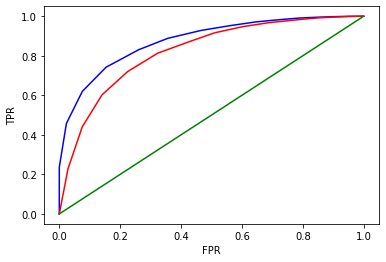

In [158]:
plotROC(list(fpr_list[9]),list(tpr_list[9]),list(fprt_list[9]),list(tprt_list[9]))

In [159]:
model_kd_wv = KNeighborsClassifier(n_neighbors = 21,algorithm = 'kd_tree')
model_kd_wv.fit(X_train,y_train)

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=21, p=2,
                     weights='uniform')

In [160]:
test_wv_predict = model_kd_wv.predict(X_test)

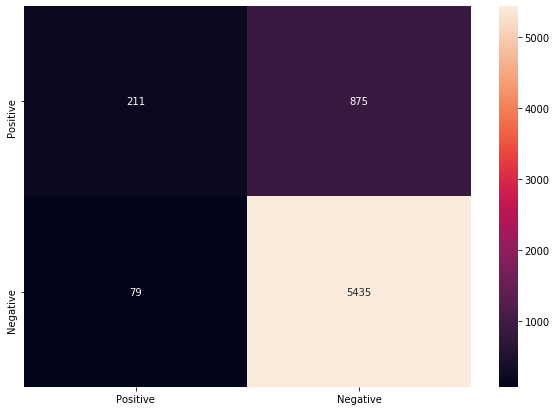

In [161]:
cm = confusion_matrix(y_test, test_wv_predict)
df_cm = pd.DataFrame(cm, index = ["Positive", "Negative"],
                  columns = ["Positive", "Negative"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True , fmt = 'g')

# [6] Conclusions

In [163]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Parameter","Bag of Words", "TF-IDF","Avg W2V","TFIDF W2V"]

x.add_row(["Brute Force best K",19,9,21,21])
x.add_row(["Brute Force best AUC",0.6604,0.50565,0.8578,0.8218])
x.add_row(["Brute Force TN",6611,6713,5420,5429])
x.add_row(["Brute Force FN",1169,1286,804,867])
x.add_row(["Brute Force FP",103,1,94,85])
x.add_row(["Brute Force TP",117,0,282,219])
x.add_row(["KD Tree best K",21,21,21,21])
x.add_row(["KD Tree best AUC",0.7596,0.5724,0.8578,0.8219])
x.add_row(["KD Tree TN",5317,5424,5420,5435])
x.add_row(["KD Tree FN",866,1010,804,875])
x.add_row(["KD Tree FP",197,90,94,79])
x.add_row(["KD Tree TP",220,76,282,211])
print(x)

+----------------------+--------------+---------+---------+-----------+
|      Parameter       | Bag of Words |  TF-IDF | Avg W2V | TFIDF W2V |
+----------------------+--------------+---------+---------+-----------+
|  Brute Force best K  |      19      |    9    |    21   |     21    |
| Brute Force best AUC |    0.6604    | 0.50565 |  0.8578 |   0.8218  |
|    Brute Force TN    |     6611     |   6713  |   5420  |    5429   |
|    Brute Force FN    |     1169     |   1286  |   804   |    867    |
|    Brute Force FP    |     103      |    1    |    94   |     85    |
|    Brute Force TP    |     117      |    0    |   282   |    219    |
|    KD Tree best K    |      21      |    21   |    21   |     21    |
|   KD Tree best AUC   |    0.7596    |  0.5724 |  0.8578 |   0.8219  |
|      KD Tree TN      |     5317     |   5424  |   5420  |    5435   |
|      KD Tree FN      |     866      |   1010  |   804   |    875    |
|      KD Tree FP      |     197      |    90   |    94   |     

# Summary and Observations:

-  Considered a sample of 30k datapoints. (Box Running times)
-  Plotted Error plots based on K values
-  Shown Confusion Matrix using sns heatmap, Majorly saw most of the points are classifing as positive.
-  Used PrettyTable to show all the data as a table manner.
-  from the table we can see that TF-IDF on brute force gave less test error compared to other models.
-  Intrestingly noted that, on AVG W2V and TF-IDF W2V on both algorithms gave exactly same results.
